# MNIST MLP VAE
This notebook demonstrates the encoding of MNIST written numeral data using a simple multi-layer perceptron (MLP) variational autoencoder (VAE) with much code borrowed from [Keras Examples Variational Autoencoder](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py) which in turn is based on ["Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114).

This notebook specifically uses the Keras API for Tensorflow so as to help understand how models are built using Keras.

This notebook is being used to:
1. Understand the Keras API
2. Understand VAE
3. Understand deep learning in general

For this reason if there is something incorrect or you think could be done better please let me know. I make no claim that everything in her is correct, but I do try my best.

# Import modules and important packages

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.reset_default_graph()

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.12.0


# Import Data
Here we import the data using the Keras provided MNIST dataset.
We then select a random image in the training dataset to demonstrate the need for normalizing the data between 0 and 1 rather than 0 and 255.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
img_index = np.random.randint(0,X_train.shape[0]-1)

# Raw data
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(X_train[img_index])
plt.title('Raw Data for Image ' + str(img_index))
plt.colorbar()

# Processed data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
plt.subplot(212)
plt.title('Normalized Data for Image ' + str(img_index))
plt.imshow(X_train[img_index])
plt.colorbar()

# Reshaping data
image_size = X_train.shape[1]
original_dim = image_size**2
X_train = np.reshape(X_train, [-1, original_dim])
X_test = np.reshape(X_test, [-1, original_dim])

# Control variables


In [31]:
# n_latent: The number of latent variables to map to in the encoder network. 
# original_dim: Length of vector for image data
# intermediate_dim: Length of hidden layer
n_latent = 2
original_dim = X_train.shape[1] 
input_shape = (original_dim,)
intermediate_dim = 512 
epochs = 10
batch = 128

# Encoder
Here we begin the code for the encoder network. We start by definind a function _sampling_ that will take in the latent space tensors and generate a new tensor that is a sampling on the normal distribution N(0,1). We do this by applying a *Labmda* layer, which is a wrapping of a function on the inputs of the function. This is required because the tensorflow background requires the data to flow as a tensor the whole way through. If we were to just apply this function directly to the tensor outside a layer an error would be thrown.

784
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lam

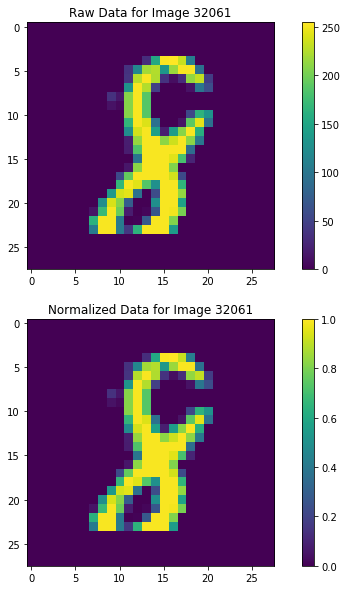

In [30]:
def sampling(args):
    mn, sd = args
    batch = tf.shape(mn)[0]
    dim = tf.shape(mn)[1]
    eps = tf.random_normal(shape=(batch,dim))
    return mn + tf.exp(0.5 * sd) * eps


inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(512, activation='relu')(inputs)
z_mean = Dense(n_latent, name='z_mean')(x)
z_log_var = Dense(n_latent, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(n_latent,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# Decoder
Here we begin the code for the decoder network. It is a very simply MLP that takes in the latent space, passes it through a single dense layer and outputs a 784 length vector using a sigmoid activation function.

In [5]:
latent_inputs = Input(shape=(n_latent,),name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)


decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


# Full Model

Here we generate the full model by running the encoder model with _inputs_ and then feeding the sampled _z_ variable to the decoder.

We then define the loss function as a combination of either MSE OR Binary Crossentropy loss _plus_ KL Divergence Loss and manually set the loss fuction for _vae_.

In [28]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs,outputs, name='vae_mlp')
vae.summary()

reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


# Training

In [29]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch,
        validation_data=(X_test, None))

vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 36us/step - loss: 225.2498 - val_loss: 230.3648
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 224.8466 - val_loss: 230.2388
Epoch 3/50
60000/60000 [==============================] - 2s 26us/step - loss: 224.6275 - val_loss: 230.0162
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 224.4808 - val_loss: 229.9969
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 224.2912 - val_loss: 230.0097
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 224.1177 - val_loss: 229.7136
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 223.9644 - val_loss: 229.7453
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 223.7707 - val_loss: 229.4896
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss:

# Generate a new image

Here we are sampling a random normal distribution via the variable _sample_ and then feeding that into the _decoder_ network. This then generates a novel image based on the latent space sampling of mean and stddev. Running the cell muliple times will generate new novel images for each sampling.

It is worth noting that the network does not know what it is generating and cannot be controlled directly at this point. Only by understanding the latent space (or developing hooks into the latent space) can we deterministically generate a given numeral.

Text(0.5, 1.0, 'Generated Image')

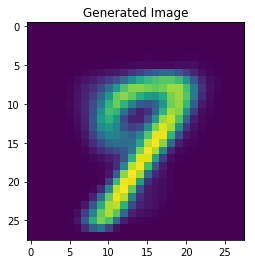

In [74]:
sample = np.random.normal(size=(1,n_latent))
sample_image = decoder.predict(sample)
sample_image = sample_image.reshape(28,28)
plt.imshow(sample_image)
plt.title('Generated Image')

# Show latent space

Here we run the encoder model to generate the latent space vectors of the images. The latent space vectors (mean & stddev) are then plotted by color to show the general domains they occupy in the latent space.

By visualizing the data in this way we can see how the data overlap by different numerals and which numerals intuitively have characteristics in common. For example, the numeral "0" (dark purple) is on the far left of z_mean[0] while the numeral "1" (deep blue) is on the far right of z_mean[0]. This indicates there is significant distance in the latent space between the two numerals.

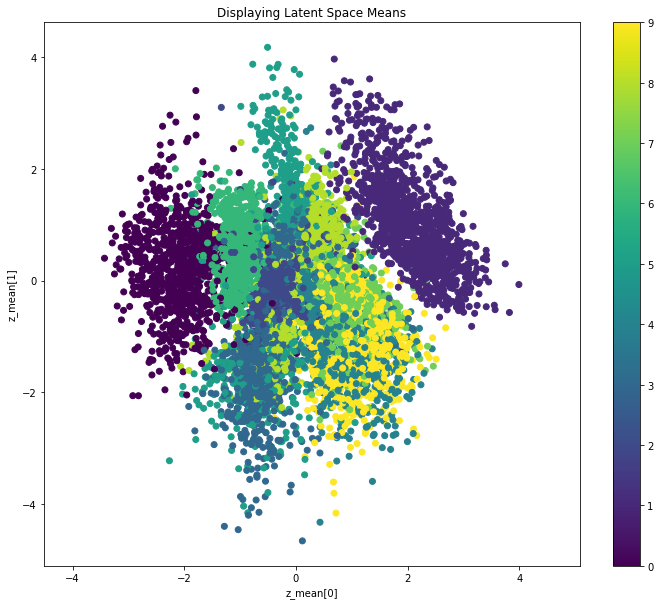

In [90]:
z_mean, z_std, _= encoder.predict(X_test)
plt.figure(figsize=(12,10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=Y_test)
plt.axis('equal')
plt.colorbar()
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
# plt.savefig('latent_space_001.png')
plt.title('Displaying Latent Space Means')
plt.show()

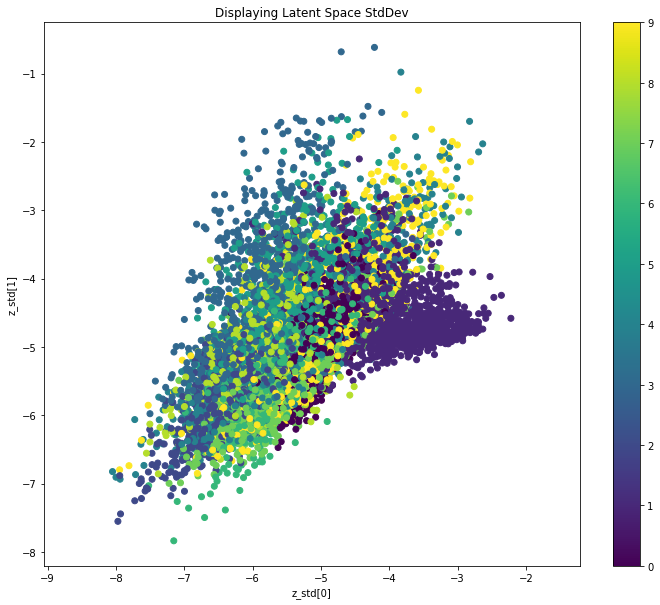

In [78]:
plt.figure(figsize=(12,10))
plt.scatter(z_std[:, 0], z_std[:, 1], c=Y_test)
plt.axis('equal')
plt.colorbar()
plt.xlabel("z_std[0]")
plt.ylabel("z_std[1]")
# plt.savefig('latent_space_002.png')
plt.title('Displaying Latent Space StdDev')
plt.show()